In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
## Brain region categorization
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','TH','VAL','VM','LGv','IMD','PT','SPA','SPFp','LH','MH','SPFm','PP','RH','IGL','IntG',
   'VPL','VPLpc','VPM','VPMpc','SubG','AMd']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl','VISpl','PAR','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','AOB','APr',
    'DP','AUDp','TT','ProS','LA','PERI','NLOT','COAa','CA2','HATA','EPv','DG-sg','DG-mo','DG-po','ENTm6',
    'BMAa','COApl','BMAp','ENTl2','ENTl1','OLF','ENTm3','PRE','PAA']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','SI','MEA','MS','LSc','AAA','MA','NDB']
HY=['AHN','DMH','HY','PH','PSTN','PVH','PVi','PeF','SBPV','TU','VMH','ZI','SUM','STN','MMd','MMme','MMl']
CB=['CENT','COPY','CUL','DEC','FL','FN','FOTU','NOD','PFL','AN','PRM','PYR','SIM','SIM','CENT3','CUL4, 5','CENT2',
   'ANcr2','ANcr1']
MB=['DR','IC','MB','MRN','MV','MY','PAG','RN','SNc','SCm','APN','PPN','RR','SNr','SAG','SCs','VTN','NOT','NB','AT',
   'CUN','PPT','MPT','VTA','CLI','NPC','IPN','IF','SCO','PN','ICe']
HB=['IRN','LRN','MDRNd','MDRNv','P','PARN','PB','PG','PGRNl','PRNc','PRNr','PSV','SPIV','SPVC','SPVO','SUV','TRN',
   'V','VCO','NLL','CS','RPO','PCG','LDT','PCG','DTN','SPVI','LRNm','NI','KF']
fiber=['fi','dhc','fr','fp','alv','cing','sm','mtt','pm','nst','or','fa','ccg','arb','mlf','ll','fx','int',
      'ccb','mfb','tspc','arb','ml','scwm']

# Load Data

In [4]:
def projection_table_generation(proj_input,target_brain_region,type_table):
    proj_input_column_names=proj_input.columns
    proj_input.rename(columns={proj_input_column_names[0]:'file_name'},inplace=True)
    
    ### split file_name into 2 columns: neuronID, arborID
    namelist=list(proj_input['file_name'].apply(lambda x:x[:-11]))
    arboridlist=list(proj_input['file_name'].apply(lambda x:x[-5:-4]))
    proj_input2=proj_input.copy()
    proj_input2.insert(loc=0,column='neuron_id',value=namelist)
    proj_input2.insert(loc=1,column='arbor_id',value=arboridlist)
    proj_input2.drop('file_name',axis=1,inplace=True)
    
    ### record soma type, projection type, arbor order, arbor type(local/distal)
    stype=[] # soma type
    ptype=[] # projection type
    LD=[] # arbor type
    a_order=[] # arbor order
    for i in range(len(proj_input2)):
        neuronID=proj_input2['neuron_id'][i]
        arborID=proj_input2['arbor_id'][i]
        row=type_table[(type_table['name']==str(neuronID))&(type_table['arbor_id']==int(arborID))]
        if len(row)<1:
            print(f'Cannnot find arbor {neuronID}_{arborID}')
            stype.append('nan')
            ptype.append('nan')
            LD.append(-1)
            a_order.append(-1)
            continue
        else:
            row_id=row.index[0]
            stype.append(type_table['stype'][row_id])
            ptype.append(type_table['ptype'][row_id])
            LD.append(type_table['LD'][row_id])
            a_order.append(type_table['arbor_order'][row_id])
    proj_input2.insert(loc=2,column='stype',value=stype)
    proj_input2.insert(loc=3,column='ptype',value=ptype)
    proj_input2.insert(loc=4,column='arbor_type',value=LD)
    proj_input2.insert(loc=5,column='arbor_order',value=a_order)
    
    ### keep arbors belong to target brain regions
    proj_row_filter=proj_input2[proj_input2['stype'].astype(str).isin(target_brain_region)]
    ### for LD, only consider TH_core
    proj_row_filter2=proj_row_filter[~((proj_row_filter['stype']=='LD')&(proj_row_filter['ptype']=='TH_core'))]
    
    ### delete column: projection length=0    
    sum_col=proj_row_filter2.sum(axis=0)
    sum_col['neuron_id']=1
    sum_col['arbor_id']=1
    sum_col['stype']=1
    sum_col['ptype']=1
    proj_col_filter=proj_row_filter2.loc[:,sum_col>0]  
    
    proj_table=proj_col_filter.copy()
    proj_table=proj_col_filter.reset_index(drop=True)
    
    return proj_table   

In [5]:
def filter_neruons(in_table, name_table_path):
    name_table = pd.read_csv(name_table_path,header=None)
    name_table.columns=['name']
    namelist = list(name_table['name'])
    out_table = in_table[in_table['Unnamed: 0'].apply(lambda x:x.split("_axon")[0]).isin(namelist)]
    return out_table

In [6]:
### target TH subtypes
th_subR=['LP','LD','LGd','VPM','PO','VPL','MG','VPLpc','VPMpc','SMT','RE','VM']
th_subR=np.array(th_subR)
rough_R=['TH','CTX','CNU','MB','HB','CB','HY']

### 1891 soma type; projection type; cortical layer
table = pd.read_csv("/Users/krystal/Desktop/project/cloud_paper/results/filtered_category.txt",sep=",")
name_filter_file = "/Users/krystal/Desktop/project/cloud_paper/1214_data/Confirmed_namelist.txt"

TH_core1=pd.read_csv("/Users/krystal/Desktop/project/cloud_paper/1214_data/TH_core_arbor_projection.csv",sep=",")
TH_matrix1=pd.read_csv("/Users/krystal/Desktop/project/cloud_paper/1214_data/TH_matrix_arbor_projection.csv",sep=",")
TH_core = filter_neruons(TH_core1, name_filter_file)
TH_matrix = filter_neruons(TH_matrix1, name_filter_file)
proj_input=pd.concat([TH_core,TH_matrix],axis=0,ignore_index=True)

In [7]:
proj_table=projection_table_generation(proj_input,th_subR,table)

# Projection Table

In [1]:
def sort_region(R,rough_R):
    ## sort projection regions involved
    L=len(rough_R)
    R_class=[[] for i in range(L)]
    for i in range(len(R)):
        flag=0
        for j in range(L):
            if R[i] in eval(rough_R[j]):
                R_class[j].append(R[i])
                flag=1
        if flag==0:
            print(f'Cannnot categorize the region {R[i]}')
    region_sorted=R_class[0]
    for k in range(1,L):
        if len(R_class[k])==0:
            continue
        R_class_ordered = sorted(R_class[k],key=lambda x:x[0])
        region_sorted=region_sorted+R_class_ordered
    return region_sorted

def calc_region(projection_table,rough_R,target_brain_region):
    col_names=projection_table.columns[6:]
    R_names=map(lambda x:x.split('_')[1], col_names)
    regions_involved=list(set(R_names))
    regions_involved.remove('fiber tracts')
    regions_sorted=sort_region(regions_involved,rough_R)
    subR_table=np.zeros((len(projection_table),len(regions_sorted)))
    projL_table=np.zeros((len(projection_table),len(regions_sorted)))
    
    for i in range(projection_table.shape[0]):
        for j in range(len(regions_sorted)):
            c1='ipsi_'+regions_sorted[j]
            c2='contra_'+regions_sorted[j]
            l=0
            if c1 in col_names:
                l+=projection_table[c1][i]
            if c2 in col_names:
                l+=projection_table[c2][i]
            n= 1 if l>0 else 0
            subR_table[i,j]+=n
            projL_table[i,j]+=l
    
    ### normalization
    stype=np.array(projection_table['stype'])
    ptable_R=[]
    ptable_L=[]
    for i in target_brain_region:
        rows1=subR_table[stype==i]
        s1=np.sum(rows1,axis=0)
        if sum(s1)==0:
            ptable_R.append(list(s1))
        else:
            ptable_R.append(list(s1/sum(s1)))  
        
        rows2=projL_table[stype==i]
        s2=np.sum(rows2,axis=0)
        if sum(s2)==0:
            ptable_L.append(list(s2))
        else:
            ptable_L.append(list(s2/sum(s2)))  
    ptable_R=np.array(ptable_R) 
    ptable_L=np.array(ptable_L)
    
    return ptable_R, ptable_L, regions_sorted  

In [8]:
ptable_R, ptable_L, regions_sorted=calc_region(proj_table,rough_R,th_subR)

# Hierachical Clustering

In [9]:
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

def load_axon_feature(proj_table,axonF_csv_path,target_brain_region):
    # read axonal feature table
    axonF=pd.read_csv(axonF_csv_path,sep=" ",header=None)
    axonF.columns=['name','arbor_id','region','max_density','num_nodes','total_path_length','volume','branch','d_to_soma','d_to_soma2','hub','variance_ratio']
    
    axonF_th=[]
    for i in range(len(proj_table)):
        name=proj_table['neuron_id'][i]
        arbor_id=proj_table['arbor_id'][i]
        line_id=axonF[(axonF['name']==str(name))&(axonF['arbor_id']==int(arbor_id))].index[0]
        axonF_th.append(list(axonF.iloc[line_id][['name','arbor_id','max_density','volume','branch','d_to_soma2']]))
    axonF_th=pd.DataFrame(axonF_th)
    axonF_th.columns=['name','arbor_id','max_density','volume','branch','d_to_soma2']
    
    ## TH: mean & std for axonal features
    stype=np.array(proj_table.stype)
    axonF_th_table=[]
    for i in target_brain_region:
        lines=axonF_th[stype==i]
        if len(lines)==0:
            mean_a=[0,0,0,0]
            std_a=[0,0,0,0]
        else:
            mean_a=list(lines[['max_density','volume','branch','d_to_soma2']].mean())
            std_a=list(lines[['max_density','volume','branch','d_to_soma2']].std())
        axonF_th_table.append(mean_a+std_a)
    axonF_th_table=np.array(axonF_th_table)
    return axonF_th_table 

def count_neuron(proj_table,target_brain_region):
    ### count number of neurons for each brain region
    cluster_label=[]
    for i in target_brain_region:
        name=proj_table[proj_table['stype']==i]['neuron_id']
        n=len(set(name))
        if i=='LD':
            i='LD*'
        label=str(i)+'\n'+'('+str(n)+')'
        cluster_label.append(label)
    return cluster_label   
        
def hierachical_clustering(projection,axon_feature,cluster_label):
    th_table=np.hstack((projection,axon_feature))
    
    plt.figure(figsize=(12,5))
    plt.grid(visible=False)
    th_scale=StandardScaler().fit_transform(th_table)
    sch.set_link_color_palette(['#FA8072','#90EE90','#87CEFA'])
    dendrogram = sch.dendrogram(sch.linkage(th_scale , method = 'ward'),labels=cluster_label,
                            leaf_rotation=0,leaf_font_size=18,color_threshold=19,above_threshold_color='grey')
    plt.yticks(fontsize=15)
    plt.savefig(f'/Users/krystal/Desktop/project/cloud_paper/1214_data/hierachical_th.png',bbox_inches='tight',pad_inches=0.2,dpi=800)

In [10]:
axon_th_table=load_axon_feature(proj_table,"/Users/krystal/Desktop/project/cloud_paper/1214_data/axon_feature.txt",th_subR)

In [11]:
cluster_label=count_neuron(proj_table,th_subR)

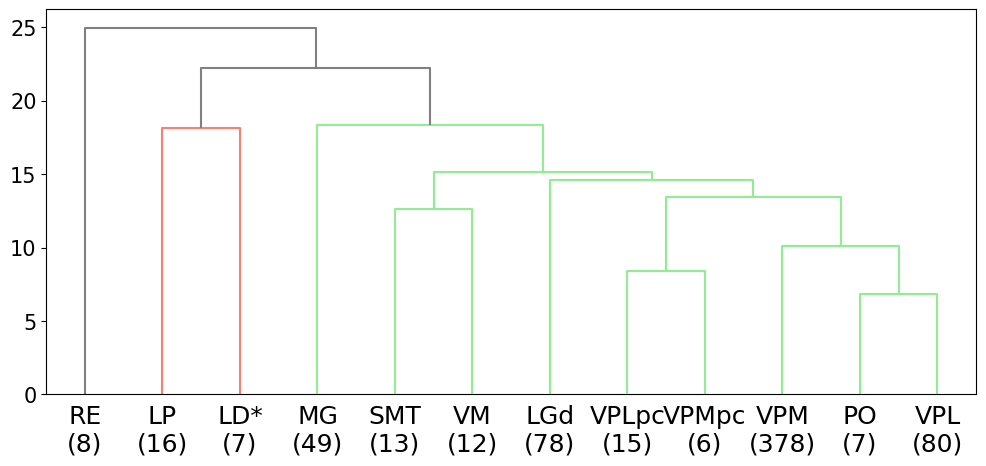

In [12]:
hierachical_clustering(ptable_L,axon_th_table,cluster_label)

# Heatmap for projection

In [13]:
def heatmap_proj(ptable,stype_reorder,target_brain_region,regions_sorted):
    plt.figure(figsize=(4,20))
    ### reorder the projection table based on classification results
    ptable_reorder=[]
    for i in stype_reorder:
        row_id=list(target_brain_region).index(i)
        ptable_reorder.append(ptable[row_id,:])
    ptable_reorder=np.array(ptable_reorder)
    
    ### scale: *100 for display only
    ax=sns.heatmap(ptable_reorder.T*100,vmin=0,vmax=17,cmap='Reds',cbar_kws={"orientation":"horizontal","shrink":0.5})
    ax=sns.heatmap(ptable_reorder.T,mask=ptable_reorder.T>0,cmap='gist_gray_r',vmin=-1,vmax=20,cbar_kws={"shrink":0.1})
    
    xlabel=stype_reorder.copy()
    xlabel[xlabel.index('LD')]='LD*'
    ax.set_xticklabels(xlabel)
    ax.set_yticks(np.arange(0+0.5,len(regions_sorted)+0.5,1),list(regions_sorted))
    plt.xticks(fontsize=15,rotation=90)
    plt.yticks(fontsize=8)
    cbar=ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.savefig(f'/Users/krystal/Desktop/project/cloud_paper/1214_data/TH_projection_heatmap.png',bbox_inches='tight',pad_inches=0.2,dpi=800)

In [16]:
subtype_sorted=['LP','LD','RE','MG','LGd','SMT','VM','PO','VPL','VPM','VPLpc','VPMpc']

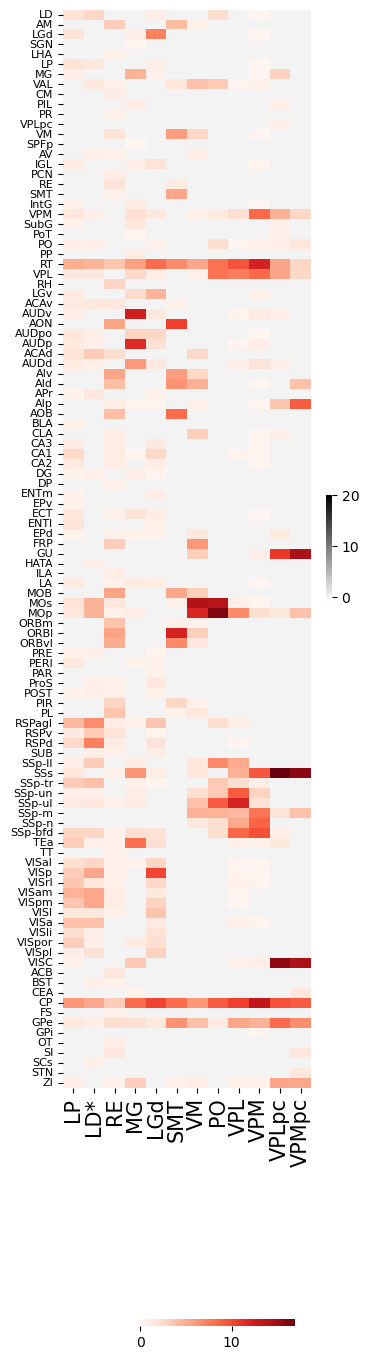

In [17]:
heatmap_proj(ptable_R,subtype_sorted,th_subR,regions_sorted)

# Major Morphological Features

In [30]:
def load_feature_table(file_path,name_filter,table):
    # read axonal feature table
    feature_input=pd.read_csv(file_path,sep=" ",header=None)
    feature_input.columns=['name','arbor_id','region','max_density','num_nodes','total_path_length','volume','branch','d_to_soma','d_to_soma2','hub','variance_ratio']
    feature_table=feature_input[feature_input['name'].isin(name_filter)]
    feature_table=feature_table.reset_index(drop=True)
    ptype=[]
    for i in range(len(feature_table)):
        row_id=table[table['name']==feature_table['name'][i]].index[0]
        ptype.append(table['ptype'][row_id])
    feature_table['projection_type']=ptype
    return feature_table

In [33]:
def feature_boxplot(subtype_sorted,axon_feature,feature_name):
    data=[]
    N=0
    for i in subtype_sorted:
        if i == 'LD':
            x=axon_feature[(axon_feature['region']==i)&(axon_feature['projection_type']=='TH_matrix')][feature_name]
        else:
            x=axon_feature[axon_feature['region']==i][feature_name]
        data.append(x)
        
    stype_rename = subtype_sorted.copy()
    stype_rename[stype_rename.index('LD')]='LD*'
    plt.figure(figsize=(10,5))
    bplot=plt.boxplot(data,widths=0.5,showmeans=False,labels=stype_rename,patch_artist=True,showfliers=False,
                 medianprops = {'linestyle':'-','color':'yellow'})
    colors=['gray','#FA8072','#FA8072','#90EE90','#90EE90','#90EE90','#90EE90','#90EE90','#90EE90',
        '#90EE90','#90EE90','#90EE90']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    plt.xticks(fontsize=16,rotation=0)
    plt.yticks(fontsize=16,rotation=0)
    #plt.savefig(f'0511/{feature_name}.png',bbox_inches='tight',pad_inches=0.2,dpi=800)

In [31]:
name_filter=pd.read_csv("0511/Final_names.txt",sep=" ",header=None)
name_filter.columns=['name']
name_filter=list(name_filter['name'])

file_path="2023/axon_feature2.txt"
axon_feature=load_feature_table(file_path,name_filter,table)

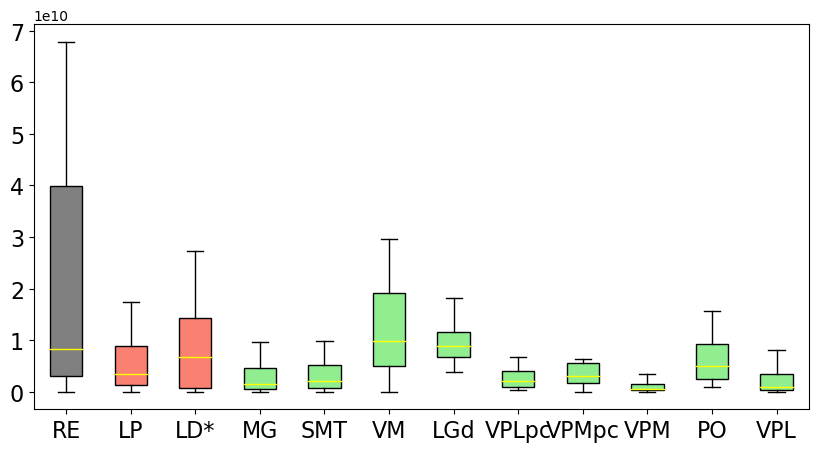

In [34]:
feature_boxplot(subtype_sorted,axon_feature,'volume')